# Evn

In [1]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [2]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# 입력 및 Vocab

In [4]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [5]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [6]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [7]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [8]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# RNN

## return sequence=False, return_state=False

In [9]:
# rnn
rnn_11 = tf.keras.layers.SimpleRNN(units = 5)
output_11 = rnn_11(hidden) # (bs, units)
print(output_11)

tf.Tensor([[ 0.0133051  -0.07108931  0.01356496  0.19825453 -0.03756267]], shape=(1, 5), dtype=float32)


In [10]:
# rnn weights
weights = rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape) # (d_model, unit)
print(Wh.shape) # (unit, unit)
print(b.shape) # (unit, )

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [11]:
# (return_sequences=True)
rnn_12 = tf.keras.layers.SimpleRNN(units = 5, return_sequences = True)
output_12 = rnn_12(hidden) # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[ 2.9929113e-02  4.1185715e-03 -7.3335785e-03 -2.7490623e-02
   -4.2592518e-02]
  [ 2.1723522e-02  3.4244298e-03 -8.8698808e-03  1.3401901e-02
   -2.1286123e-02]
  [ 4.8892803e-02 -1.5492372e-02  5.2009160e-03 -5.0389312e-02
   -6.7127943e-02]
  [ 5.3107738e-02  3.3684172e-02  4.7106575e-02  2.6926834e-02
   -1.6819069e-02]
  [ 6.6921949e-02 -6.2659383e-06  3.1169422e-02 -2.7292369e-02
    2.3001337e-02]
  [ 5.5012092e-02 -4.9766455e-02 -4.8280213e-02  2.3197087e-02
    1.8371815e-02]
  [ 1.5149739e-02 -9.3269765e-02  1.8400183e-02  7.5476407e-04
   -6.5119125e-02]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [12]:
# (return_state=True)
rnn_13 = tf.keras.layers.SimpleRNN(units = 5, return_state = True)
output_13, fw_h_13 = rnn_13(hidden) # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525434 -0.12735648]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525434 -0.12735648]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [13]:
# (return_sequences=True, return_state=True)
rnn_14 = tf.keras.layers.SimpleRNN(units = 5, return_sequences = True, return_state = True)
output_14, fw_h_14 = rnn_14(hidden) # (bs, seq, units), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[-0.00567131  0.00702238  0.0166551  -0.02649674 -0.00639815]
  [ 0.00745121  0.00397363 -0.03161482  0.00067732  0.03525217]
  [ 0.02503373  0.04381724 -0.01435504 -0.07607194 -0.03647323]
  [ 0.03158387 -0.03594297 -0.03295876  0.09170678  0.00911083]
  [-0.06396969  0.06692141  0.02803503 -0.07891872 -0.05069153]
  [ 0.03279418 -0.04417153 -0.09341431  0.0333666   0.09773416]
  [ 0.01325146  0.01543665  0.01574938 -0.08289386 -0.10723303]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.01325146  0.01543665  0.01574938 -0.08289386 -0.10723303]], shape=(1, 5), dtype=float32)


## init hidden state

In [14]:
# rnn_11 with fw_h_13
rnn_11(hidden, initial_state = [fw_h_13]) # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.06465904, -0.25594386, -0.12518847,  0.13231519, -0.02561215]],
      dtype=float32)>

In [15]:
# rnn_12 with fw_h_14
rnn_12(hidden, initial_state = [fw_h_14]) # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.08970518,  0.12074085,  0.02214284, -0.00741253,
         -0.06301705],
        [ 0.06890634,  0.02803107,  0.03387965, -0.06119582,
          0.07141123],
        [ 0.13040169, -0.04140752, -0.09347053, -0.06496175,
         -0.03006374],
        [ 0.11627129, -0.0390062 ,  0.06014571, -0.02257581,
         -0.09820992],
        [ 0.14631155,  0.0332644 ,  0.08039215,  0.05096842,
         -0.0258085 ],
        [ 0.08789143, -0.06898136,  0.05173643,  0.0284674 ,
          0.1006607 ],
        [ 0.04806692, -0.15309522, -0.04242581,  0.05481387,
          0.01750817]]], dtype=float32)>

In [16]:
# rnn_13 with fw_h_13
rnn_13(hidden, initial_state = [fw_h_13]) # (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090795, -0.01084654,  0.00649465,  0.03989044,  0.08458714]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090795, -0.01084654,  0.00649465,  0.03989044,  0.08458714]],
       dtype=float32)>]

In [17]:
# rnn_14 with fw_h_14
rnn_14(hidden, initial_state = [fw_h_14])  # (bs, n_seq, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.04023583, -0.04856527, -0.00745723,  0.08569601,
           0.03263333],
         [-0.03993218,  0.04022601, -0.0133417 , -0.1201784 ,
           0.01704529],
         [ 0.08773063, -0.04925723, -0.03939974, -0.01440458,
           0.00531509],
         [-0.01835137,  0.00441733,  0.04440122,  0.04724793,
          -0.07235702],
         [-0.06754464,  0.03039353,  0.0077003 , -0.02238409,
           0.0663793 ],
         [ 0.07404423, -0.00928033, -0.04943877, -0.06849191,
           0.03991261],
         [ 0.03545617, -0.01660541,  0.01871964,  0.04337611,
          -0.07521319]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03545617, -0.01660541,  0.01871964,  0.04337611, -0.07521319]],
       dtype=float32)>]

# LSTM

## return sequence=False, return_state=False

In [18]:
# lstm
lstm_11 = tf.keras.layers.LSTM(units = 5)
output_11 = lstm_11(hidden) # (bs, units)
print(output_11)

tf.Tensor([[ 0.01252828 -0.01186483 -0.01100005  0.00128962  0.00689079]], shape=(1, 5), dtype=float32)


In [19]:
# lstm weights
weights = lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape) # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape) # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape) # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [20]:
# (return_sequences=True)
lstm_12 = tf.keras.layers.LSTM(units = 5, return_sequences = True)
output_12 = lstm_12(hidden) # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.00544438 -0.00505095  0.00146407 -0.00019775 -0.00408297]
  [ 0.00092337  0.00106309 -0.00256752  0.00214575 -0.00409309]
  [-0.00466804 -0.00234009 -0.00467811  0.00283395 -0.01177095]
  [-0.00136526  0.00112071 -0.00880491  0.00172207 -0.00966275]
  [-0.00722189 -0.00401253 -0.00514568  0.00093245 -0.01217541]
  [-0.00101653  0.00202121 -0.00762216  0.00274471 -0.01070324]
  [ 0.00060078  0.00327611 -0.0104871   0.00319098 -0.00986872]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [21]:
# (return_state=True)
lstm_13 = tf.keras.layers.LSTM(units = 5, return_state = True)
output_13, fw_h_13, fw_c_13 = lstm_13(hidden) # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)

tf.Tensor(
[[ 7.6129837e-03 -1.5287815e-02  7.3035844e-03  4.7374528e-05
   1.1121367e-02]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[ 7.6129837e-03 -1.5287815e-02  7.3035844e-03  4.7374528e-05
   1.1121367e-02]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[ 1.5119700e-02 -3.0797761e-02  1.4539103e-02  9.5068710e-05
   2.2492610e-02]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [22]:
# (return_sequences=True, return_state=True)
lstm_14 = tf.keras.layers.LSTM(units = 5, return_sequences = True, return_state = True)
output_14, fw_h_14, fw_c_14 = lstm_14(hidden) # (bs, seq, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)

tf.Tensor(
[[[ 0.00040525 -0.00275002  0.00038114 -0.00120663  0.00231446]
  [-0.00520107 -0.00223845 -0.00043894 -0.0053069  -0.00388033]
  [-0.00688379 -0.00716671 -0.00024295 -0.00974881 -0.00305707]
  [-0.00176606 -0.0059406   0.00495924 -0.00458891 -0.00075247]
  [-0.00092784 -0.00677031  0.00413757 -0.00491618  0.00158901]
  [-0.00619131 -0.00487417  0.00241962 -0.00824052 -0.00451456]
  [-0.00361855 -0.00470538  0.00690781 -0.00543056 -0.0025354 ]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[-0.00361855 -0.00470538  0.00690781 -0.00543056 -0.0025354 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.00723412 -0.0093214   0.01380899 -0.01084146 -0.00508808]], shape=(1, 5), dtype=float32)


## init hidden state

In [23]:
# lstm_11 with fw_h_13, fw_c_13
lstm_11(hidden, initial_state=[fw_h_13, fw_c_13]) # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.01215497, -0.01394066, -0.01243898,  0.00035355,  0.00925506]],
      dtype=float32)>

In [24]:
# lstm_12 with fw_h_14, fw_c_14
lstm_12(hidden, initial_state=[fw_h_14, fw_c_14]) # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-7.3097218e-03, -8.6579267e-03,  6.5108277e-03, -4.6995520e-03,
         -6.1655948e-03],
        [ 2.5162593e-04, -1.8132351e-03,  1.2117121e-03, -1.3395882e-03,
         -5.7245716e-03],
        [-4.5920075e-03, -4.5240764e-03, -1.8206030e-03,  4.4292374e-05,
         -1.3040293e-02],
        [-8.1744191e-04, -5.4931070e-04, -6.6617574e-03, -3.8644686e-04,
         -1.0613153e-02],
        [-6.4202966e-03, -5.2729584e-03, -3.5087359e-03, -6.8675214e-04,
         -1.2861537e-02],
        [-8.9272165e-05,  1.0454296e-03, -6.3446397e-03,  1.5852144e-03,
         -1.1164520e-02],
        [ 1.5599113e-03,  2.5538309e-03, -9.4951764e-03,  2.3441282e-03,
         -1.0163450e-02]]], dtype=float32)>

In [25]:
# lstm_13 with fw_h_13, fw_c_13
lstm_13(hidden, initial_state=[fw_h_13, fw_c_13]) # (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01113445, -0.0181876 ,  0.01266127, -0.00279448,  0.01636327]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01113445, -0.0181876 ,  0.01266127, -0.00279448,  0.01636327]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.02208105, -0.03670878,  0.02523495, -0.0056196 ,  0.03310997]],
       dtype=float32)>]

In [26]:
# lstm_14 with fw_h_14, fw_c_14
lstm_14(hidden, initial_state=[fw_h_14, fw_c_14]) # (bs, n_seq, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.00241018, -0.00558355,  0.00569973, -0.0054552 ,
           0.00055526],
         [-0.00738834, -0.00379501,  0.00365711, -0.00856859,
          -0.00504782],
         [-0.0085752 , -0.00787436,  0.00294753, -0.01219721,
          -0.00383559],
         [-0.00311176, -0.00611526,  0.00749481, -0.00639922,
          -0.00124679],
         [-0.00200747, -0.00661883,  0.00610426, -0.00623128,
           0.00128764],
         [-0.00705873, -0.00454286,  0.00394774, -0.00918079,
          -0.00467455],
         [-0.00432382, -0.00428938,  0.00812357, -0.00609291,
          -0.00260176]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00432382, -0.00428938,  0.00812357, -0.00609291, -0.00260176]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00864326, -0.00849324,  0.016246  , -0.01216442, -0.00522   ]],
       dtype=float32)>]

# GRU

## return sequence=False, return_state=False

In [27]:
# GRU
gru_11 = tf.keras.layers.GRU(units = 5)
output_11 = gru_11(hidden) # (bs, units)
print(output_11)

tf.Tensor([[-0.00128841  0.01591058 -0.01686392 -0.00689237 -0.01078903]], shape=(1, 5), dtype=float32)


In [28]:
# GRU weights
weights = gru_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape) # (d_model, unit * 3) (Wxr, Wxz, Wxg)
print(Wh.shape) # (unit, unit * 3) (Whr, Whz, Whg)
print(b.shape) # (2, unit * 3) (bxr, bxz, bxg),(bhr, bhz, bhg)

(4, 15)
(5, 15)
(2, 15)


## return sequence=True, return_state=False

In [29]:
# (return_sequences=True)
gru_12 = tf.keras.layers.GRU(units = 5, return_sequences = True)
output_12 = gru_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.00724988 -0.01204025 -0.00660731 -0.00241936  0.01091108]
  [-0.00690028 -0.00760665  0.00473171  0.02366268  0.02218487]
  [-0.01982779 -0.02418694 -0.000265    0.03126299  0.04256844]
  [-0.00805993 -0.00707422  0.00594501  0.02301816  0.02065855]
  [-0.0146784  -0.0149042  -0.00365479  0.01337637  0.02291579]
  [-0.01298529 -0.00852203  0.00638297  0.03420675  0.02937598]
  [-0.01063064 -0.00421955  0.01115373  0.0308162   0.02547237]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [31]:
# (return_state=True)
gru_13 = tf.keras.layers.GRU(units = 5, return_state = True)
output_13, fw_h_13 = gru_13(hidden)  # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.0019341   0.01071739  0.00788937  0.01066312 -0.00221146]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.0019341   0.01071739  0.00788937  0.01066312 -0.00221146]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [32]:
# (return_sequences=True, return_state=True)
gru_14 = tf.keras.layers.GRU(units = 5, return_sequences = True, return_state = True)
output_14, fw_h_14 = gru_14(hidden)  # (bs, seq, units * 2), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[-0.00381347  0.00607597  0.00153289  0.00026855  0.01145666]
  [-0.00331714  0.01010486 -0.01224199 -0.01133284  0.00853806]
  [-0.00093711  0.01803945 -0.0145158  -0.01409486  0.02851611]
  [ 0.00880802  0.01154291 -0.0096231  -0.00740737  0.012196  ]
  [ 0.00363141  0.01305108 -0.00426213 -0.00214698  0.01840561]
  [ 0.00235771  0.01434101 -0.01598028 -0.01207952  0.01253426]
  [ 0.00402145  0.01470503 -0.0129416  -0.01024149  0.00994625]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.00402145  0.01470503 -0.0129416  -0.01024149  0.00994625]], shape=(1, 5), dtype=float32)


## init hidden state

In [33]:
gru_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.00140842,  0.01592344, -0.01623747, -0.00670336, -0.01101907]],
      dtype=float32)>

In [34]:
gru_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.00300019, -0.00323922, -0.01454308, -0.00958822,
          0.01849951],
        [-0.00319965, -0.00230684, -0.00040348,  0.0188137 ,
          0.02772161],
        [-0.01684529, -0.02090497, -0.00366238,  0.02805248,
          0.04653085],
        [-0.00582952, -0.00502904,  0.00368652,  0.0209058 ,
          0.02341765],
        [-0.01303946, -0.01359165, -0.00516605,  0.01199155,
          0.02483771],
        [-0.01180617, -0.00767625,  0.00535123,  0.03328608,
          0.03071455],
        [-0.00979845, -0.00366684,  0.01045386,  0.03020769,
          0.02639962]]], dtype=float32)>

In [35]:
gru_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>]

In [36]:
gru_14(hidden, initial_state=[fw_h_14]) # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.00120912,  0.01436689, -0.00526015, -0.00245608,
           0.01752719],
         [ 0.00106435,  0.0148916 , -0.01622299, -0.01184704,
           0.01214018],
         [ 0.00249824,  0.02077618, -0.01704834, -0.01405097,
           0.03059548],
         [ 0.01132524,  0.01315177, -0.01130751, -0.0072835 ,
           0.01345716],
         [ 0.00543236,  0.0139883 , -0.00539421, -0.00206096,
           0.01916937],
         [ 0.00361664,  0.0148993 , -0.01673315, -0.01203724,
           0.01301165],
         [ 0.00488993,  0.01504152, -0.01344696, -0.01023171,
           0.01024941]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00488993,  0.01504152, -0.01344696, -0.01023171,  0.01024941]],
       dtype=float32)>]

# Bidirectional RNN

## return sequence=False, return_state=False

In [37]:
# bi rnn
#rnn_11 = tf.keras.layers.SimpleRNN(units = 5)
bi_rnn_11 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 5))
output_11 = bi_rnn_11(hidden) # (bs, units * 2)
print(output_11)

tf.Tensor(
[[ 0.00189245 -0.08352485 -0.07952984 -0.02134595  0.01254619 -0.10349478
  -0.0285648  -0.15433243  0.04896942  0.06491221]], shape=(1, 10), dtype=float32)


In [38]:
# bi rnn weights
weights = bi_rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape) # (d_model, unit)
print(Wh.shape) # (unit, unit)
print(b.shape) # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [39]:
# (return_sequences=True)
bi_rnn_12 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 5, return_sequences = True))
output_12 = bi_rnn_12(hidden) # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[ 0.02063903  0.03965816  0.03919788  0.02908318 -0.02135444
    0.03373569  0.14357285  0.02265848 -0.01834988  0.01760596]
  [-0.06732997  0.0119262   0.01037599  0.03202324 -0.04788924
   -0.02202282 -0.12320485  0.00310691  0.03954257  0.02772265]
  [-0.0069248   0.09928044  0.00049278  0.0842956  -0.02588288
    0.02357069  0.03469789  0.06235293 -0.08903261  0.01622928]
  [-0.10489257  0.04832265  0.01487477  0.05294417  0.00262039
   -0.02221388 -0.06631253 -0.00934883  0.01024336  0.03339538]
  [-0.02521386  0.11432075  0.0165207   0.04469954  0.06719342
    0.04058785  0.02231554 -0.00393319 -0.01607522  0.03056315]
  [-0.08703329  0.0155736   0.07161146  0.08565228  0.04799198
    0.02592861 -0.0405432  -0.03698469 -0.03118086  0.01623693]
  [-0.0069922   0.11693995  0.02447139  0.02125133  0.06086859
   -0.0062323  -0.04051992 -0.00674628 -0.02538863 -0.00846069]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [40]:
# (return_state=True)
bi_rnn_13 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 5,return_state = True))
output_13, fw_h_13, bw_h_13 = bi_rnn_13(hidden) # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[ 0.10142464  0.04384788  0.03959855  0.09941956  0.05877534  0.19237266
  -0.0812621   0.04585575  0.21233375 -0.06199192]], shape=(1, 10), dtype=float32)
tf.Tensor([[0.10142464 0.04384788 0.03959855 0.09941956 0.05877534]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.19237266 -0.0812621   0.04585575  0.21233375 -0.06199192]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [41]:
# (return_sequences=True, return_state=True)
bi_rnn_14 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 5,return_sequences = True, return_state = True))
output_14, fw_h_14, bw_h_14 = bi_rnn_14(hidden) # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-0.01223004 -0.03604717 -0.01213866  0.00832459 -0.00985193
   -0.06842467  0.03804656 -0.21594404 -0.07498586  0.12322078]
  [-0.01207433 -0.02585809  0.01065563  0.01178059 -0.05265585
    0.07812028 -0.15373422 -0.00190183 -0.13922727  0.13310388]
  [-0.0369997  -0.07803842  0.04209687  0.04328766 -0.0377161
    0.07696803  0.08312834 -0.0637846  -0.02303878  0.17275529]
  [-0.03149062 -0.00641296  0.09045608  0.04872282 -0.02032937
   -0.06239615 -0.07913799  0.00644676 -0.02948124  0.07311696]
  [-0.00251457  0.00482455  0.03361512  0.09806919 -0.01537912
    0.00374245  0.03065289 -0.0893319  -0.05894311  0.0406061 ]
  [ 0.06832523  0.01860224  0.02926934  0.06120522 -0.07875361
    0.03820577 -0.03235298  0.02452953 -0.05579672  0.06007537]
  [ 0.07677121  0.03446358  0.09452506 -0.03025864  0.00149059
    0.02181129  0.02294274 -0.00379264 -0.01796763  0.03280125]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.07677121  0.03446358  0.09452506 -0.03025864  0.00

## init hidden state

In [42]:
# bi_rnn_11 with fw_h_13, bw_h_13
bi_rnn_11(hidden, initial_state=[fw_h_13, bw_h_13]) # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.03366552,  0.02708556, -0.08833596,  0.02204747,  0.11622974,
        -0.09725527, -0.23567978, -0.14445539,  0.18366566, -0.04445881]],
      dtype=float32)>

In [43]:
# bi_rnn_12 with fw_h_14, bw_h_14
bi_rnn_12(hidden, initial_state=[fw_h_14, bw_h_14]) # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.00958689,  0.03306837,  0.121411  , -0.05310354,
         -0.069801  , -0.00270117,  0.3421622 ,  0.0594316 ,
          0.04920284, -0.08195023],
        [-0.08903914, -0.00823849, -0.0190354 , -0.08953566,
         -0.03271431, -0.14414804, -0.26751798,  0.14107466,
          0.11605854, -0.01104443],
        [ 0.02232581, -0.00883719, -0.02639926,  0.04660335,
          0.01856824,  0.02391086,  0.2328768 ,  0.21018218,
         -0.13730294,  0.04852048],
        [ 0.01353182,  0.0045039 ,  0.00479941,  0.05030999,
         -0.02010383, -0.12037753, -0.16119115,  0.04842468,
          0.18212932,  0.15873075],
        [ 0.00532184,  0.08084926,  0.03913519,  0.04759575,
         -0.05087128,  0.16545373,  0.07834654,  0.14952204,
         -0.1347118 ,  0.14144842],
        [-0.11827581,  0.02918995,  0.00035898,  0.04068657,
         -0.04247621, -0.04291085, -0.0464942 , -0.14875293,
          0.07161848,  0.22109677],


In [44]:
# bi_rnn_13 with fw_h_13, bw_h_13
bi_rnn_13(hidden, initial_state=[fw_h_13, bw_h_13]) # (bs, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 0.21820247,  0.12051318,  0.03422751,  0.10649262,  0.11619177,
          0.31769818, -0.1452783 ,  0.04461537,  0.30978465,  0.12155465]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.21820247, 0.12051318, 0.03422751, 0.10649262, 0.11619177]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.31769818, -0.1452783 ,  0.04461537,  0.30978465,  0.12155465]],
       dtype=float32)>]

In [45]:
# bi_rnn_14 with fw_h_14, bw_h_14
bi_rnn_14(hidden, initial_state=[fw_h_14, bw_h_14]) # (bs, n_seq, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-0.01605418,  0.08521216,  0.0078772 , -0.0052132 ,
           0.02986129, -0.08073806, -0.1815616 , -0.25961483,
          -0.1164571 ,  0.19696285],
         [ 0.04976505,  0.01947389, -0.06751592,  0.02501593,
           0.01579403,  0.17407653, -0.08744309, -0.17113188,
          -0.17401794,  0.25746423],
         [ 0.01264184, -0.07194784, -0.03912848, -0.03732142,
          -0.07277703,  0.09552309, -0.07634459, -0.01732119,
           0.0321065 ,  0.3469225 ],
         [-0.05013778, -0.04536489,  0.09190015, -0.06441393,
           0.02577551, -0.14590359, -0.03704872, -0.19435067,
          -0.02591169,  0.20409103],
         [-0.11520644,  0.00189497, -0.0134646 ,  0.07705233,
           0.02070227,  0.04140927, -0.18265297, -0.11942258,
          -0.15420507,  0.14669563],
         [ 0.038363  , -0.0723078 , -0.03828006,  0.11328387,
          -0.0663591 ,  0.12099791,  0.06455711, -0.10884315,
          -0.07171

# Bidirectional LSTM

## return sequence=False, return_state=False

In [46]:
# lstm
bi_lstm_11 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 5))
output_11 = bi_lstm_11(hidden) # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.01047844 -0.00272136  0.01447616 -0.015981   -0.00944974 -0.01022396
   0.00184914  0.00054924  0.01690395  0.00960285]], shape=(1, 10), dtype=float32)


In [47]:
# lstm weights
weights = bi_lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape) # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape) # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape) # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [48]:
# (return_sequences=True)
bi_lstm_12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 5, return_sequences = True))
output_12 = bi_lstm_12(hidden) # (bs, seq, units * 2)
print(output_12)

tf.Tensor(
[[[ 0.00572704  0.00143487 -0.00331461 -0.00193452 -0.00626948
    0.00095727 -0.00672461  0.00755316 -0.00082623 -0.00279788]
  [-0.00464334 -0.00477877 -0.00704962 -0.00027559  0.00117185
   -0.00306182 -0.0122618   0.01030242 -0.00170412 -0.00148065]
  [-0.00122711 -0.00535861 -0.01451639 -0.00197635 -0.00332223
    0.00109893 -0.00459027  0.00640099  0.00262677 -0.00232618]
  [-0.00385974 -0.00179318 -0.00893673  0.0011897  -0.00094004
   -0.00352854  0.00051255  0.00387651  0.00455648 -0.00036182]
  [ 0.00240173  0.00063563 -0.01005731 -0.00161065 -0.00760287
   -0.0011374  -0.00527796  0.00479362  0.00015036 -0.00207249]
  [-0.00728943 -0.00494088 -0.01211869 -0.00037022 -0.000363
   -0.00581124 -0.00962973  0.00659043 -0.00069188 -0.00031079]
  [-0.0091411  -0.00195886 -0.01065393  0.00111449  0.00126692
   -0.00256846 -0.00012026  0.00160678  0.00367497 -0.00049144]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [49]:
# (return_state=True)
# (return_sequences=True)
bi_lstm_13 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 5, return_state = True))
output_13, fw_h_13, fw_c_13, bw_h_13, bw_c_13 = bi_lstm_13(hidden) # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)
print(bw_h_13)
print(bw_c_13)

tf.Tensor(
[[-0.00669851 -0.01033889 -0.00779064  0.01347378 -0.00082833  0.01547839
   0.00376636 -0.00398766 -0.00370576 -0.00819959]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.00669851 -0.01033889 -0.00779064  0.01347378 -0.00082833]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01344749 -0.02074135 -0.01553759  0.02708873 -0.0016644 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.01547839  0.00376636 -0.00398766 -0.00370576 -0.00819959]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.03100743  0.00752903 -0.00798306 -0.00741232 -0.01623809]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [50]:
# (return_sequences=True, return_state=True)
bi_lstm_14 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 5, return_sequences = True, return_state = True))
output_14, fw_h_14, fw_c_14, bw_h_14, bw_c_14 = bi_lstm_14(hidden) # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)
print(bw_h_14)
print(bw_c_14)

tf.Tensor(
[[[-1.73568190e-03  9.66656313e-04 -4.43200534e-03  9.81729099e-05
    5.99584915e-03  3.58588551e-03  6.28273701e-03 -9.33102972e-04
    1.30135426e-03 -1.71137247e-02]
  [-7.28761358e-03 -3.23330332e-03 -9.18741710e-03 -7.00382702e-03
   -2.57872860e-03  4.31145914e-03  1.27696879e-02  2.18096841e-03
   -2.25784932e-03 -2.00917311e-02]
  [-1.40764881e-02 -5.22490079e-03 -2.07485575e-02 -9.74385813e-03
    3.33819329e-03 -7.73745996e-05  9.84441210e-03  1.33407488e-03
    2.33387039e-03 -1.52610773e-02]
  [-1.04366727e-02 -7.36432569e-03 -1.33569920e-02 -7.55398208e-03
    6.90099332e-05 -1.78182847e-03  4.63476637e-03  1.80065760e-03
   -4.06197691e-03 -6.97691925e-03]
  [-9.36021190e-03 -4.31238348e-03 -1.47491610e-02 -6.92136539e-03
    6.73899520e-03  2.75624800e-03  5.51511627e-03  2.85831135e-04
   -1.84834193e-04 -9.86234285e-03]
  [-1.27383284e-02 -6.90077711e-03 -1.69051476e-02 -1.33840917e-02
   -1.56315230e-03  3.62244830e-03  1.00047905e-02  3.20798019e-03
   -5

## init hidden state

In [51]:
# bi_lstm_11 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_11(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13]) # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.01044984, -0.00225714,  0.01167913, -0.01586506, -0.00975995,
        -0.0087426 ,  0.00403183,  0.00167814,  0.01551284,  0.00888616]],
      dtype=float32)>

In [52]:
# bi_lstm_12 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_12(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14]) # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.00296111, -0.00444816, -0.01440736, -0.01289157,
         -0.00957924,  0.00093291, -0.00624854,  0.00838793,
          0.00082277, -0.00327455],
        [-0.01074373, -0.00835391, -0.01588251, -0.00926945,
         -0.0018043 , -0.00317167, -0.01164459,  0.01119183,
          0.00026823, -0.0024432 ],
        [-0.00562839, -0.00747657, -0.02159042, -0.00929105,
         -0.00604211,  0.00091913, -0.00373623,  0.00726371,
          0.00502075, -0.00402418],
        [-0.00698529, -0.00291855, -0.01446473, -0.00463477,
         -0.00348325, -0.00369615,  0.00173964,  0.00464657,
          0.00733154, -0.00328682],
        [ 0.0001484 ,  0.00010467, -0.01450157, -0.0061196 ,
         -0.00992879, -0.00114119, -0.00346304,  0.00535879,
          0.00317948, -0.00670312],
        [-0.00884963, -0.00511036, -0.01564908, -0.0037656 ,
         -0.00250201, -0.00530665, -0.00690272,  0.00683172,
          0.00226493, -0.00769371],


In [53]:
# bi_lstm_13 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_13(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13]) # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.00782868, -0.01307623, -0.00731933,  0.01435827, -0.00225139,
          0.01593335,  0.0055482 , -0.0060663 , -0.00531265, -0.01116456]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00782868, -0.01307623, -0.00731933,  0.01435827, -0.00225139]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01571303, -0.02624407, -0.01459285,  0.02888137, -0.00452371]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01593335,  0.0055482 , -0.0060663 , -0.00531265, -0.01116456]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03193098,  0.01108811, -0.01215264, -0.01063845, -0.02210738]],
       dtype=float32)>]

In [54]:
# bi_lstm_14 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_14(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14]) # (bs, n_seq, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-1.04460837e-02, -5.75428503e-03, -1.51174720e-02,
          -1.06630009e-02,  4.14686464e-03,  4.68043843e-03,
           4.43026749e-03, -2.26083072e-03, -1.06409343e-03,
          -1.94848534e-02],
         [-1.34683149e-02, -7.94618204e-03, -1.70644000e-02,
          -1.61122922e-02, -3.28263198e-03,  5.61679387e-03,
           1.07295765e-02,  5.99681400e-04, -4.72701201e-03,
          -2.32779253e-02],
         [-1.85028408e-02, -8.59788433e-03, -2.64112875e-02,
          -1.75623894e-02,  3.32411169e-03,  1.51165540e-03,
           7.80272018e-03, -4.54908790e-04, -1.74976391e-04,
          -1.95330251e-02],
         [-1.35340365e-02, -9.73690581e-03, -1.73044503e-02,
          -1.38761597e-02,  4.28098312e-04,  8.07055985e-05,
           2.85251974e-03, -1.78919843e-04, -6.44189958e-03,
          -1.27323698e-02],
         [-1.15437629e-02, -5.96557371e-03, -1.73409078e-02,
          -1.22294575e-02,  7.28086615e-03

# Bidirectional GRU

## return sequence=False, return_state=False

In [55]:
# bi GRU
bi_gru_11 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 5))
output_11 = bi_gru_11(hidden) # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.00072184 -0.016904    0.00711801 -0.00559251  0.00739438  0.01164481
   0.00828551 -0.00861709  0.00493614 -0.01986348]], shape=(1, 10), dtype=float32)


In [56]:
# bi GRU weights
weights = bi_gru_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape) # (d_model, unit * 3) (Wxr, Wxz, Wxg)
print(Wh.shape)  # (unit, unit * 3) (Whr, Whz, Whg)
print(b.shape) # (2, unit * 3) (bxr, bxz, bxg),(bhr, bhz, bhg)

(4, 15)
(5, 15)
(2, 15)


## return sequence=True, return_state=False

In [57]:
# (return_sequences=True)
bi_gru_12 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 5, return_sequences = True))
output_12 = bi_gru_12(hidden) # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[ 0.00068553 -0.0042389   0.0029039  -0.00035927 -0.00499255
    0.00271537  0.01382237  0.00265203  0.00407036 -0.00154717]
  [-0.00377441 -0.01477874  0.00418696  0.02414083  0.00199853
    0.02274144  0.00590778  0.00116065  0.00471965  0.0065552 ]
  [-0.00396749 -0.0225128   0.00355693  0.03395787 -0.00608305
    0.00573862  0.01581501 -0.00148708  0.00681403 -0.00675571]
  [-0.01229045 -0.00900376 -0.0012757   0.02379612 -0.00839744
    0.0037635   0.01124475 -0.00305182  0.00304518 -0.00639333]
  [-0.00532181 -0.00932149  0.00288593  0.01211448 -0.00818051
    0.00347679  0.01212953  0.00254687  0.00217574  0.00073128]
  [-0.00674273 -0.01755711  0.00437381  0.03060742  0.0007513
    0.02407692  0.00230935  0.00095978  0.00179878  0.00960551]
  [-0.01551554 -0.01325507  0.0045301   0.02898801 -0.00646983
    0.00765511  0.00840811 -0.00218095  0.00238035 -0.00317473]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [58]:
# (return_state=True)
bi_gru_13 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 5, return_state = True))
output_13, fw_h_13, bw_h_13 = bi_gru_13(hidden) # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[-0.00090163 -0.02939906 -0.00681299  0.00333673 -0.00652324 -0.01461007
  -0.00590369  0.00853587 -0.00181723 -0.00886709]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.00090163 -0.02939906 -0.00681299  0.00333673 -0.00652324]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01461007 -0.00590369  0.00853587 -0.00181723 -0.00886709]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [59]:
# (return_sequences=True, return_state=True)
bi_gru_14 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 5, return_sequences = True, return_state = True))
output_14, fw_h_14, bw_h_14 = bi_gru_14(hidden) # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-0.00544995  0.00655301  0.00508489  0.00244967  0.00328198
    0.01886513  0.01990128 -0.00551106  0.00665467  0.01657994]
  [ 0.01110324 -0.00934234 -0.01514423  0.00014308 -0.00704704
    0.03488777  0.00499167 -0.00988165  0.01538127  0.03170763]
  [ 0.0076507  -0.00871916 -0.01256944  0.00839841 -0.00676278
    0.0159151   0.01561383 -0.01603252  0.01622044  0.02766158]
  [ 0.01060414 -0.01359599 -0.01609579  0.00704759  0.0001731
    0.00293907  0.00393714 -0.00164059  0.00913611  0.00610813]
  [ 0.0006414  -0.00185265 -0.00161888  0.00305068  0.00071399
    0.01375607  0.01290924 -0.00463978  0.0031499   0.01363201]
  [ 0.0146883  -0.01410105 -0.01737136 -0.00077821 -0.00977928
    0.02662695 -0.00578056 -0.00502988  0.00954117  0.02461229]
  [ 0.01761476 -0.01647723 -0.01906318 -0.00072876 -0.0052701
    0.00358339 -0.00039039 -0.00187687  0.00689455  0.01056525]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.01761476 -0.01647723 -0.01906318 -0.00072876 -0.005

## init hidden state

In [60]:
# bi_gru_11 with fw_h_13, bw_h_13
bi_gru_11(hidden, initial_state = [fw_h_13, bw_h_13]) # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.00097017, -0.01680927,  0.00690556, -0.00532796,  0.00735713,
         0.01122481,  0.00843973, -0.00886281,  0.00488845, -0.02003367]],
      dtype=float32)>

In [61]:
# bi_gru_12 with fw_h_14, bw_h_14
bi_gru_12(hidden, initial_state = [fw_h_14, bw_h_14]) # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[ 0.01003567, -0.01330033, -0.00890842,  0.00226917,
         -0.00535741,  0.00255519,  0.01405214,  0.00251961,
          0.00427602, -0.0019304 ],
        [ 0.0010978 , -0.01961865, -0.00293531,  0.02695254,
          0.00270392,  0.02243672,  0.00640564,  0.0009083 ,
          0.00501816,  0.00605991],
        [-0.00141706, -0.02504733, -0.00062125,  0.03616212,
         -0.00540411,  0.00522034,  0.01686105, -0.00192042,
          0.00723664, -0.00728109],
        [-0.01092186, -0.0103073 , -0.00362688,  0.02533162,
         -0.00793402,  0.00304753,  0.01333423, -0.00371864,
          0.00363845, -0.00668393],
        [-0.00460081, -0.00999622,  0.00158908,  0.01310625,
         -0.00790445,  0.00287434,  0.01613623,  0.00160112,
          0.00304435,  0.00130376],
        [-0.00636261, -0.01790997,  0.00366269,  0.03120724,
          0.00090734,  0.02471342,  0.00957251, -0.00034251,
          0.00322722,  0.0124059 ],


In [62]:
# bi_gru_13 with fw_h_13, bw_h_13
bi_gru_13(hidden, initial_state = [fw_h_13, bw_h_13])  # (bs, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.00122181, -0.03043102, -0.00705071,  0.00330191, -0.00681734,
         -0.01464406, -0.00587261,  0.0086585 , -0.00156047, -0.00876512]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00122181, -0.03043102, -0.00705071,  0.00330191, -0.00681734]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01464406, -0.00587261,  0.0086585 , -0.00156047, -0.00876512]],
       dtype=float32)>]

In [63]:
# bi_gru_14 with fw_h_14, bw_h_14
bi_gru_14(hidden, initial_state = [fw_h_14, bw_h_14])  # (bs, n_seq, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[ 0.00446973, -0.00312266, -0.0010965 , -0.00093646,
          -0.002727  ,  0.01932765,  0.02079922, -0.00454842,
           0.00643312,  0.01671551],
         [ 0.01694998, -0.01448501, -0.0162008 , -0.0026829 ,
          -0.01173537,  0.03568403,  0.00641577, -0.00848698,
           0.01514674,  0.03192825],
         [ 0.01123352, -0.01126999, -0.01185337,  0.00653127,
          -0.00995402,  0.01730921,  0.01784242, -0.01409317,
           0.01604296,  0.02802754],
         [ 0.01289474, -0.01475499, -0.01507284,  0.00593094,
          -0.00182648,  0.00535893,  0.00743459,  0.00096093,
           0.00916668,  0.00673261],
         [ 0.00214239, -0.00230722, -0.00075521,  0.0023927 ,
          -0.0004468 ,  0.01792869,  0.01841142, -0.00153466,
           0.00367646,  0.01496594],
         [ 0.01566955, -0.01422789, -0.01675266, -0.00116246,
          -0.01041054,  0.03372113,  0.00284986, -0.00204534,
           0.01104

# RNN 모델

In [64]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    RNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    ########################################
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 128, return_sequences = True))(hidden) # (bs, 128)
    hidden = tf.keras.layers.SimpleRNN(units = 128, return_sequences = True)(hidden)
    # rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=128, return_sequences=True))
    # hidden = rnn_1(hidden)  # (bs, 128)
    # rnn_2 = tf.keras.layers.SimpleRNN(units=128, return_sequences=True)
    # hidden = rnn_2(hidden)
    ########################################

    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

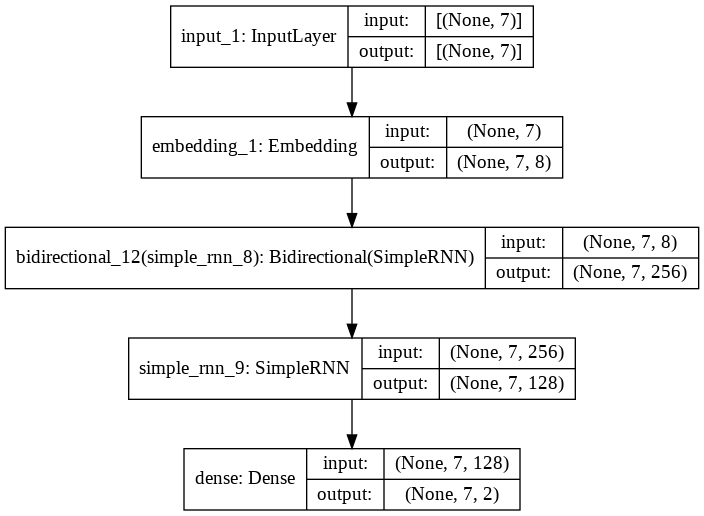

In [65]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [66]:
model.predict(train_inputs)

array([[[0.51912874, 0.4808712 ],
        [0.5130567 , 0.48694333],
        [0.506221  , 0.49377903],
        [0.4905734 , 0.5094266 ],
        [0.53359216, 0.46640778],
        [0.47992492, 0.52007514],
        [0.47854427, 0.52145576]]], dtype=float32)